# Analyzing machine learning model training results #

## A NOTE BEFORE STARTING ##

Since the ``emicroml`` git repository tracks this notebook under its original
basename ``analyzing_ml_model_training_results.ipynb``, we recommend that you
copy the original notebook and rename it to any other basename that is not one
of the original basenames that appear in the ``<root>/examples`` directory
before executing any of the notebook cells below, where ``<root>`` is the root
of the ``emicroml`` repository. For example, you could rename it
``analyzing_ml_model_training_results_sandbox.ipynb``. This way you can explore
the notebook by executing and modifying cells without changing the original
notebook, which is being tracked by git.

## Table of contents ##

- [Import necessary modules](#Import-necessary-modules)
- [Introduction](#Introduction)
- [Loading and analyzing the ML training dataset](#Loading-and-analyzing-the-ML-training-dataset)
- [Loading and analyzing the ML model training summary output data](#Loading-and-analyzing-the-ML-model-training-summary-output-data)
- [Loading and using a trained ML model](#Loading-and-using-a-trained-ML-model)
- [A note on `fancytypes`](#A-note-on-fancytypes)

## Import necessary modules ##

In [1]:
# For pattern matching.
import re

# For listing files and subdirectories in a given directory, and for renaming
# directories.
import os

# For adding new directories in which to search for local Python modules. Only
# used at the end of the current notebook cell.
import sys



# For general array handling.
import numpy as np
import torch

# For loading objects from HDF5 files.
import h5pywrappers

# For creating, plotting, and closing figures.
import matplotlib.pyplot as plt



# For loading ML datasets and models for distortion estimation in CBED.
import emicroml.modelling.cbed.distortion.estimation

# For visualizing some data. Users need not focus on the implementation details
# of this module in order to follow the logic of each cell in the remainder of
# this notebook. Morevoer, users need not import this module for their own
# applications of ``emicroml``.
sys.path.insert(0, "..")
import helpers.for_analyzing_ml_model_training_results as helpers

## Introduction ##

In this notebook, we analyze the output that results from performing the
"actions" described in the following pages:

1. [Generating machine learning datasets for training and validation](https://mrfitzpa.github.io/emicroml/examples/modelling/cbed/distortion/estimation/generate_ml_datasets_for_training_and_validation.html)
2. [Combining then splitting machine learning datasets for training and validation](https://mrfitzpa.github.io/emicroml/examples/modelling/cbed/distortion/estimation/combine_ml_datasets_for_training_and_validation_then_split.html)
3. [Training machine learning models](https://mrfitzpa.github.io/emicroml/examples/modelling/cbed/distortion/estimation/train_ml_model_set.html)

while also demonstrating how one can use a selection of the functions and
classes in the module
[emicroml.modelling.cbed.distortion.estimation](https://mrfitzpa.github.io/emicroml/_autosummary/emicroml.modelling.cbed.distortion.estimation.html#module-emicroml.modelling.cbed.distortion.estimation).
In short, in this notebook we analyze machine learning (ML) model training
results for the ML task of estimating distortion in convergent beam electron
diffraction (CBED).

In order to execute the cells in this notebook as intended, a set of Python
libraries need to be installed in the Python environment within which the cells
of the notebook are to be executed. For this particular notebook, users need to
install:

    torch
    jupyter
    ipympl
    emicroml

Before installing `emicroml`, it is recommended that users install `torch`
(i.e. `PyTorch`) in the same environment that they intend to install `emicroml`
according to the instructions given
[here](https://pytorch.org/get-started/locally/) for their preferred `PyTorch`
installation option. After installing `torch`, users can install the remaining
libraries by running the following command in a terminal:

    pip install emicroml jupyter ipympl

The `emicroml` repository contains a script located at
`<root>/default_env_setup_for_slurm_jobs.sh` that will attempt to create a
virtual environment, then activate it, and then install all the libraries
required to run all of the examples in said repository, when executed with
appropriately chosen command line arguments. As an alternative to the manual
installation procedure above, users can try the automated approach that involves
executing the aforementioned script. See [this
page](https://mrfitzpa.github.io/emicroml/examples/prerequisites_for_execution_without_slurm.html)
for instructions on how to do so.

A subset of the output that results from performing the "actions" mentioned at
the beginning of this section is required to execute the cells in this notebook
as intended. One can obtain this subset of output by executing said actions,
however this requires significant computational resources, including significant
walltime. Alternatively, one can copy this subset of output from a Federated
Research Data Repository (FRDR) dataset by following the instructions given on
[this
page](https://mrfitzpa.github.io/emicroml/examples/modelling/cbed/distortion/estimation/copying_subset_of_output_from_frdr_dataset.html).
For this particular notebook, the only files that one would need to copy from
the FRDR dataset are:

    <frdr_dataset_root>/emicroml/examples/modelling/cbed/distortion/estimation/data/ml_datasets/ml_dataset_for_training.h5
    
    <frdr_dataset_root>/emicroml/examples/modelling/cbed/distortion/estimation/data/ml_datasets/ml_dataset_for_validation.h5
    
    <frdr_dataset_root>/emicroml/examples/modelling/cbed/distortion/estimation/data/ml_models/ml_model_1/ml_model_training_summary_output_data.h5
    
    <frdr_dataset_root>/emicroml/examples/modelling/cbed/distortion/estimation/data/ml_models/ml_model_1/ml_model_at_lr_step_<step_count>.pth

where `<frdr_dataset_root>` is the root of the FRDR dataset, and `<step_count>`
is an integer.

You can find the documentation for the `emicroml` library
[here](https://mrfitzpa.github.io/emicroml/_autosummary/emicroml.html). It is
recommended that you consult the documentation of this library as you explore
the notebook. Moreover, users should execute the cells in the order that they
appear, i.e. from top to bottom, as some cells reference variables that are set
in other cells above them. **Users should make sure to navigate the
documentation for the version of `emicroml` that they are currently using.**

The last module that we imported above (i.e. the module with the alias
`helpers`) contains helper functions that are used throughout the remainder of
the notebook, specifically to visualize some data. It is not essential that
users know the implementation details of these helper functions in order to
follow the logic of each cell in the remainder of this notebook. Moreover, users
need not import this module for their own applications of `emicroml`. That being
said, if any users are interested in the implementation details, they can find
them in the file
`<root>/examples/modelling/cbed/distortion/estimation/helpers/for_analyzing_ml_model_training_results.py`.

## Loading and analyzing the ML training dataset ##

Upon successful completion of the action described in the page [Combining then
splitting machine learning datasets for training and
validation](https://mrfitzpa.github.io/emicroml/examples/modelling/cbed/distortion/estimation/combine_ml_datasets_for_training_and_validation_then_split.html),
ML training and validation datasets are stored in the HDF5 files at the file
paths ``../data/ml_datasets/ml_dataset_for_training.h5`` and
``../data/ml_datasets/ml_dataset_for_validation.h5`` respectively.

Let's look at some of the ML data instances stored in the ML training dataset,
namely the first five to start:

In [2]:
path_to_data_dir = "../data"
path_to_ml_dataset = (path_to_data_dir
                      + "/ml_datasets/ml_dataset_for_training.h5")

module_alias = emicroml.modelling.cbed.distortion.estimation
kwargs = {"path_to_ml_dataset": path_to_ml_dataset, 
          "entire_ml_dataset_is_to_be_cached": False, 
          "ml_data_values_are_to_be_checked": False}
ml_dataset = module_alias.MLDataset(**kwargs)



single_dim_slice = slice(0, 5)

kwargs = {"single_dim_slice": single_dim_slice, 
          "unnormalize_normalizable_elems": True}
ml_data_instances = ml_dataset.get_ml_data_instances(**kwargs)

Next, let's print the names of all the features of the ML data instances:

In [3]:
for key in ml_data_instances:
    print(key)

cbed_pattern_images
disk_overlap_maps
disk_clipping_registries
disk_objectness_sets
common_undistorted_disk_radii
undistorted_disk_center_sets
distortion_centers
quadratic_radial_distortion_amplitudes
elliptical_distortion_vectors
spiral_distortion_amplitudes
parabolic_distortion_vectors


The features of the ML data instances are described in detail
[here](https://mrfitzpa.github.io/emicroml/_autosummary/emicroml.modelling.cbed.distortion.estimation.generate_and_save_ml_dataset.html).

The normalizable features/elements of ML data instances stored in the HDF5 files
are expected to be min-max normalized. To determine whether a feature is
normalizable, simply check either the normalization weights or biases of the ML
dataset:

In [4]:
ml_dataset.normalization_weights

{'common_undistorted_disk_radii': 10.085433491152902,
 'undistorted_disk_center_sets': 0.8538026559831683,
 'distortion_centers': 1.4834175929231184,
 'quadratic_radial_distortion_amplitudes': 0.5844875306693489,
 'elliptical_distortion_vectors': 4.232790782464268,
 'spiral_distortion_amplitudes': 0.6910054343539491,
 'parabolic_distortion_vectors': 1.5356486116549626}

If the name of a feature appears in the above dictionary, then that feature is
normalizable.

In the first code block of this section, we loaded a subset of ML data instances
and then subsequently unnormalized the normalizable features of said
subset. This was done in a single call to the method
[emicroml.modelling.cbed.distortion.estimation.MLDataset.get_ml_data_instances](https://mrfitzpa.github.io/emicroml/_autosummary/emicroml.modelling.cbed.distortion.estimation.MLDataset.html#emicroml.modelling.cbed.distortion.estimation.MLDataset.get_ml_data_instances).

Alternatively, we can do this in two steps:

In [5]:
kwargs = {"single_dim_slice": single_dim_slice, 
          "unnormalize_normalizable_elems": False}
ml_data_instances = ml_dataset.get_ml_data_instances(**kwargs)

# The following code block modifies ``ml_data_instances`` in place.
module_alias = emicroml.modelling.cbed.distortion.estimation
kwargs = {"ml_data_dict": ml_data_instances,
          "normalization_weights": ml_dataset.normalization_weights,
          "normalization_biases": ml_dataset.normalization_biases}
module_alias.unnormalize_normalizable_elems_in_ml_data_dict(**kwargs)

For completeness, we show the inverse operation of normalizing the unnormalized
normalizable features:

In [6]:
module_alias = emicroml.modelling.cbed.distortion.estimation
kwargs = {"ml_data_dict": ml_data_instances,
          "normalization_weights": ml_dataset.normalization_weights,
          "normalization_biases": ml_dataset.normalization_biases}
module_alias.normalize_normalizable_elems_in_ml_data_dict(**kwargs)

Rather than load the subset of ML data instances as a dictionary of arrays, we
can load the subset as a sequence `HyperSpy` signals:

In [7]:
cbed_pattern_image = ml_data_instances["cbed_pattern_images"][0]
sampling_grid_dims_in_pixels = cbed_pattern_image.shape

kwargs = \
    {"single_dim_slice": single_dim_slice, 
     "sampling_grid_dims_in_pixels": sampling_grid_dims_in_pixels}
ml_data_instances_as_signals = \
    ml_dataset.get_ml_data_instances_as_signals(**kwargs)

Let's plot one of the signals, which represents a single ML data instance:

In [8]:
%matplotlib ipympl

cbed_pattern_idx = 0
ml_data_instance_as_signal = ml_data_instances_as_signals[cbed_pattern_idx]

kwargs = {"axes_off": True, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 0.2,
          "cmap": "plasma", 
          "title": ""}
ml_data_instance_as_signal.plot(**kwargs)

And here's the signal's metadata:

In [9]:
ml_data_instance_as_signal.metadata

├── FakeCBED
│   ├── cbed_pattern_image_has_been_overridden = True
│   ├── disk_absence_registry <tuple>
│   │   ╠══ [0] = False
│   │   ╠══ [1] = False
│   │   ╠══ [10] = False
│   │   ╠══ [11] = False
│   │   ╠══ [12] = False
│   │   ╠══ [13] = False
│   │   ╠══ [14] = False
│   │   ╠══ [15] = False
│   │   ╠══ [16] = False
│   │   ╠══ [17] = False
│   │   ╠══ [18] = False
│   │   ╠══ [19] = False
│   │   ╠══ [2] = False
│   │   ╠══ [20] = False
│   │   ╠══ [21] = False
│   │   ╠══ [22] = False
│   │   ╠══ [23] = False
│   │   ╠══ [24] = False
│   │   ╠══ [25] = False
│   │   ╠══ [26] = False
│   │   ╠══ [27] = False
│   │   ╠══ [28] = False
│   │   ╠══ [29] = False
│   │   ╠══ [3] = False
│   │   ╠══ [30] = False
│   │   ╠══ [31] = False
│   │   ╠══ [32] = False
│   │   ╠══ [33] = False
│   │   ╠══ [34] = False
│   │   ╠══ [35] = False
│   │   ╠══ [36] = False
│   │   ╠══ [37] = False
│   │   ╠══ [38] = False
│   │   ╠══ [39] = False
│   │   ╠══ [4] = False
│   │   ╠══ [40] = False
│   │   ╠══ [41] = False
│   │   ╠══ [42] = False
│   │   ╠══ [43] = False
│   │   ╠══ [44] = False
│   │   ╠══ [45] = False
│   │   ╠══ [46] = False
│   │   ╠══ [5] = False
│   │   ╠══ [6] = False
│   │   ╠══ [7] = False
│   │   ╠══ [8] = False
│   │   ╚══ [9] = False
│   ├── disk_clipping_registry <tuple>
│   │   ╠══ [0] = False
│   │   ╠══ [1] = False
│   │   ╠══ [10] = False
│   │   ╠══ [11] = False
│   │   ╠══ [12] = False
│   │   ╠══ [13] = False
│   │   ╠══ [14] = False
│   │   ╠══ [15] = True
│   │   ╠══ [16] = True
│   │   ╠══ [17] = False
│   │   ╠══ [18] = False
│   │   ╠══ [19] = False
│   │   ╠══ [2] = True
│   │   ╠══ [20] = False
│   │   ╠══ [21] = False
│   │   ╠══ [22] = True
│   │   ╠══ [23] = True
│   │   ╠══ [24] = False
│   │   ╠══ [25] = False
│   │   ╠══ [26] = True
│   │   ╠══ [27] = False
│   │   ╠══ [28] = False
│   │   ╠══ [29] = False
│   │   ╠══ [3] = False
│   │   ╠══ [30] = True
│   │   ╠══ [31] = True
│   │   ╠══ [32] = False
│   │   ╠══ [33] = True
│   │   ╠══ [34] = True
│   │   ╠══ [35] = False
│   │   ╠══ [36] = True
│   │   ╠══ [37] = True
│   │   ╠══ [38] = True
│   │   ╠══ [39] = False
│   │   ╠══ [4] = False
│   │   ╠══ [40] = True
│   │   ╠══ [41] = True
│   │   ╠══ [42] = True
│   │   ╠══ [43] = True
│   │   ╠══ [44] = True
│   │   ╠══ [45] = True
│   │   ╠══ [46] = True
│   │   ╠══ [5] = False
│   │   ╠══ [6] = True
│   │   ╠══ [7] = False
│   │   ╠══ [8] = False
│   │   ╚══ [9] = False
│   ├── num_disks = 47
│   └── pre_serialized_core_attrs
│       ├── apply_shot_noise = False
│       ├── cold_pixels = ()
│       ├── detector_partition_width_in_pixels = 0
│       ├── distortion_model
│       │   ├── coord_transform_params
│       │   │   ├── center = (0.7486820220947266, 0.7271223068237305)
│       │   │   ├── radial_cosine_coefficient_matrix = ((0.0, 0.0, 1.320096492767334), (0.0, 0.09190169721841812, 0.0), (0.012371511198580265, 0.0, 0.0))
│       │   │   ├── radial_sine_coefficient_matrix = ((0.0, -0.05310411378741264), (0.03372572734951973, 0.0))
│       │   │   ├── tangential_cosine_coefficient_matrix = ((0.0, 0.0, -0.024458587169647217), (0.0, -0.017701371262470882, 0.0), (0.03372572734951973, 0.0, 0.0))
│       │   │   └── tangential_sine_coefficient_matrix = ((0.0, -0.03063389907280604), (-0.012371511198580265, 0.0))
│       │   ├── device_name = None
│       │   ├── least_squares_alg_params
│       │   │   ├── factor_for_decreasing_damping = 9.0
│       │   │   ├── factor_for_increasing_damping = 11.0
│       │   │   ├── improvement_tol = 0.1
│       │   │   ├── initial_damping = 0.001
│       │   │   ├── max_num_iterations = 10
│       │   │   ├── plateau_patience = 2
│       │   │   ├── plateau_tol = 0.001
│       │   │   └── rel_err_tol = 0.01
│       │   └── sampling_grid_dims_in_pixels = (512, 512)
│       ├── gaussian_filter_std_dev = 0.0
│       ├── mask_frame = (0, 0, 0, 0)
│       ├── num_pixels_across_pattern = 512
│       ├── rng_seed = None
│       ├── undistorted_disks <tuple>
│  

See
[here](https://mrfitzpa.github.io/fakecbed/_autosummary/fakecbed.discretized.CBEDPattern.html#fakecbed.discretized.CBEDPattern.signal)
for a detailed description of the signal data and metadata. See also
[here](https://mrfitzpa.github.io/emicroml/_autosummary/emicroml.modelling.cbed.distortion.estimation.MLDataset.html#emicroml.modelling.cbed.distortion.estimation.MLDataset.get_ml_data_instances_as_signals)
for additional context. Note that some, if not many, of these simulated CBED
patterns do not appear realistic. This is deliberate as we are primarily
concerned with generating ML datasets storing simulated CBED patterns that
capture the essential geometric features of real CBED patterns, namely perfectly
circular CBED disks in the absence of distortion. The placement of the CBED
disks are often unusual, but this is also deliberate.

An alternative way to load a subset of ML data instances as a sequence of
`HyperSpy` signals is as follows:

In [10]:
kwargs = {"single_dim_slice": single_dim_slice, 
          "unnormalize_normalizable_elems": True}
ml_data_instances = ml_dataset.get_ml_data_instances(**kwargs)

module_alias = emicroml.modelling.cbed.distortion.estimation
kwargs = {"ml_data_dict": ml_data_instances,
          "sampling_grid_dims_in_pixels": sampling_grid_dims_in_pixels}
ml_data_instances_as_signals = module_alias.ml_data_dict_to_signals(**kwargs)

## Loading and analyzing the ML model training summary output data ##

Upon successful completion of the action described in the page [Training machine
learning
models](https://mrfitzpa.github.io/emicroml/examples/modelling/cbed/distortion/estimation/train_ml_model_set.html),
10 ML models are trained, and a dictionary representation of each ML model is
saved to a file. Moreover, the ML model training summary output data for each
trained ML model is saved to a HDF5 file. ML model training summary output files
are described in detail in the documentation for the method
[emicroml.modelling.cbed.distortion.estimation.MLModelTrainer.train_ml_model](https://mrfitzpa.github.io/emicroml/_autosummary/emicroml.modelling.cbed.distortion.estimation.MLModelTrainer.html#emicroml.modelling.cbed.distortion.estimation.MLModelTrainer.train_ml_model).
Let's examine the contents of one such HDF5 file.

Let's start by looking at the ML model training parameters used to train one of
the ML models. Said parameters have been serialized and stored in the HDF5 file:

In [11]:
path_to_ml_model_training_summary_output_data = \
    (path_to_data_dir
     + "/ml_models/ml_model_1"
     + "/ml_model_training_summary_output_data.h5")



kwargs = {"filename": path_to_ml_model_training_summary_output_data,
          "path_in_file": "ml_model_trainer_params"}
json_document_id = h5pywrappers.obj.ID(**kwargs)

serializable_rep_of_ml_model_trainer_params = \
    h5pywrappers.json.document.load(json_document_id)

serializable_rep_of_ml_model_trainer_params

{'ml_dataset_manager': {'ml_training_dataset': {'path_to_ml_dataset': '/localscratch/mfitzpat.49022012.0/ml_datasets/ml_dataset_for_training.h5',
   'entire_ml_dataset_is_to_be_cached': False,
   'ml_data_values_are_to_be_checked': True,
   'max_num_ml_data_instances_per_chunk': 32},
  'ml_validation_dataset': {'path_to_ml_dataset': '/localscratch/mfitzpat.49022012.0/ml_datasets/ml_dataset_for_validation.h5',
   'entire_ml_dataset_is_to_be_cached': False,
   'ml_data_values_are_to_be_checked': True,
   'max_num_ml_data_instances_per_chunk': 32},
  'ml_testing_dataset': None,
  'mini_batch_size': 64,
  'rng_seed': 20001,
  'num_data_loader_workers': 32},
 'device_name': None,
 'checkpoints': None,
 'lr_scheduler_manager': {'lr_schedulers': [{'lr_scheduler_name': 'sequential',
    'lr_scheduler_params': {'non_sequential_lr_schedulers': [{'lr_scheduler_name': 'linear',
       'lr_scheduler_params': {'ml_optimizer': {'ml_optimizer_name': 'sgd',
         'ml_optimizer_params': {'base_lr': 0

The above output is a serialized representation of the ML model trainer
parameters used to train the ML model. ML model trainers are represented by the
[emicroml.modelling.cbed.distortion.estimation.MLModelTrainer](https://mrfitzpa.github.io/emicroml/_autosummary/emicroml.modelling.cbed.distortion.estimation.MLModelTrainer.html)
class. Instances of this class are used to train ML models. We can construct an
instance of this class using the above serialized representation of the ML model
trainer parameters, as long as the parameter values are valid, including those
that specify the paths to the ML training and validation datasets (to be)
used. It's possible that these paths are invalid in
``serializable_rep_of_ml_model_trainer_param`` as they may refer to temporary
locations of the ML training and validation datasets during training, e.g. if
the training was performed in a SLURM job. For demonstration purposes, let's
reset these paths to ensure a successful construction of an instance of the
above class:

In [12]:
phases = ("training", "validation")

for phase in phases:
    key_1 = "ml_dataset_manager"
    key_2 = "ml_{}_dataset".format(phase)
    key_3 = "path_to_ml_dataset"

    path_to_ml_dataset = (path_to_data_dir
                          + "/ml_datasets"
                          + "/ml_dataset_for_{}.h5".format(phase))

    serializable_rep_of_ml_model_trainer_params[key_1][key_2][key_3] = \
        path_to_ml_dataset

Now we can construct the ML model trainer using the serialized representation of
the ML model trainer parameters (note that this may take some time):

In [13]:
module_alias = emicroml.modelling.cbed.distortion.estimation
kwargs = {"serializable_rep": serializable_rep_of_ml_model_trainer_params}
ml_model_trainer = module_alias.MLModelTrainer.de_pre_serialize(**kwargs)

Apart from parameters specifying paths, this ML model trainer has the same
parameters as those used to train the ML model referenced in the page [Training
a machine learning
model](https://mrfitzpa.github.io/emicroml/examples/modelling/cbed/distortion/estimation/train_ml_model_set.html).

Let's extract the mini-batch size from
``serializable_rep_of_ml_model_trainer_params``, which we use further below for
visualization purposes:

In [14]:
serializable_rep_of_ml_dataset_manager = \
    serializable_rep_of_ml_model_trainer_params["ml_dataset_manager"]
mini_batch_size = \
    serializable_rep_of_ml_dataset_manager["mini_batch_size"]

From the ML model training summary output data file, we can also extract the
number of training and validation mini-batches processed per epoch:

In [15]:
phase_to_num_mini_batches_per_epoch_map = dict()

for phase in phases:
    hdf5_dataset_path = "num_{}_mini_batches_per_epoch".format(phase)
    
    kwargs = {"filename": path_to_ml_model_training_summary_output_data,
              "path_in_file": hdf5_dataset_path}
    hdf5_dataset_id = h5pywrappers.obj.ID(**kwargs)

    kwargs = {"dataset_id": hdf5_dataset_id, "read_only": True}
    num_mini_batches_per_epoch = h5pywrappers.dataset.load(**kwargs)[()]

    phase_to_num_mini_batches_per_epoch_map[phase] = \
        num_mini_batches_per_epoch

    unformatted_msg = "# {} mini-batches per epoch: {}"
    msg = unformatted_msg.format(phase, num_mini_batches_per_epoch)
    print(msg)

# training mini-batches per epoch: 7920
# validation mini-batches per epoch: 1980


We can also extract the learning rate schedules used:

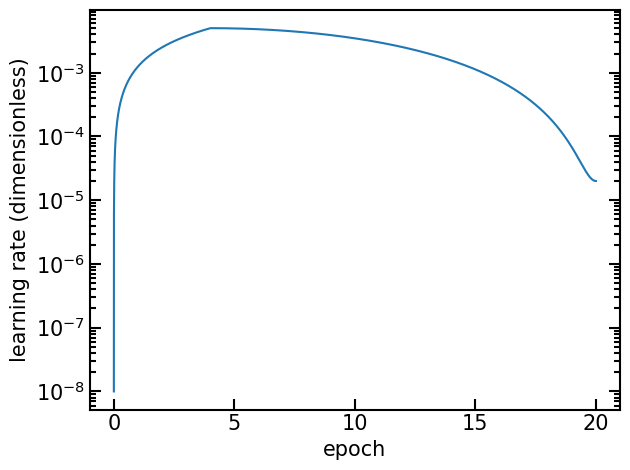

In [16]:
kwargs = {"filename": path_to_ml_model_training_summary_output_data,
          "path_in_file": "/lr_schedules/lr_schedule_0"}
hdf5_dataset_id = h5pywrappers.obj.ID(**kwargs)

kwargs = {"dataset_id": hdf5_dataset_id, "read_only": True}
lr_schedule = h5pywrappers.dataset.load(**kwargs)[()]



kwargs = {"obj_id": hdf5_dataset_id, "attr_name": "dim_0"}
attr_id = h5pywrappers.attr.ID(**kwargs)

kwargs = {"attr_id": attr_id}
dim_0_of_lr_schedule = h5pywrappers.attr.load(**kwargs)



y = lr_schedule
x = np.arange(y.size).astype("float")
if dim_0_of_lr_schedule == "training mini batch instance idx":
    x /= phase_to_num_mini_batches_per_epoch_map["training"].astype("float")



plt.close("all")  # Close all previous figures to release memory.
%matplotlib inline

kwargs = {"x": x,
          "y": y,
          "x_label": "epoch",
          "y_label": "learning rate (dimensionless)"}
helpers.plot_single_xy_curve(**kwargs)

We can also extract the metrics used to track ML model performance during
training. In the cell below, for both the training and validation phases, we
extract the end-point errors (EPEs) of the predicted "adjusted" standard
distortion fields:

In [17]:
phase_to_epes_of_adjusted_distortion_fields_map = dict()

for phase in phases:
    hdf5_dataset_path = ("/ml_data_instance_metrics"
                         "/{}/epes_of_adjusted_distortion_fields".format(phase))
    
    kwargs = {"filename": path_to_ml_model_training_summary_output_data,
              "path_in_file": hdf5_dataset_path}
    hdf5_dataset_id = h5pywrappers.obj.ID(**kwargs)

    kwargs = {"dataset_id": hdf5_dataset_id, "read_only": True}
    epes_of_adjusted_distortion_fields = h5pywrappers.dataset.load(**kwargs)

    phase_to_epes_of_adjusted_distortion_fields_map[phase] = \
        epes_of_adjusted_distortion_fields

For both the training and validation phases, let's group the EPEs by epoch, so
that we can perform quartile analysis per epoch further below:

In [18]:
phase_to_epes_of_adjusted_distortion_fields_grouped_by_epoch_map = dict()

for phase in phases:
    num_mini_batches_per_epoch = \
        phase_to_num_mini_batches_per_epoch_map[phase]
    epes_of_adjusted_distortion_fields = \
        phase_to_epes_of_adjusted_distortion_fields_map[phase]



    num_ml_data_instances_in_ml_dataset = \
        (num_mini_batches_per_epoch * mini_batch_size)
    num_ml_data_instances_in_ml_dataset = \
        min(num_ml_data_instances_in_ml_dataset,
            epes_of_adjusted_distortion_fields.size)



    start = 0
    stop = (epes_of_adjusted_distortion_fields.size
            - (epes_of_adjusted_distortion_fields.size
               % num_ml_data_instances_in_ml_dataset))
    single_dim_slice = slice(start, stop)

    

    array_to_reshape = \
        epes_of_adjusted_distortion_fields[single_dim_slice]
    epes_of_adjusted_distortion_fields_grouped_by_epoch = \
        array_to_reshape.reshape(-1, num_ml_data_instances_in_ml_dataset)


    
    phase_to_epes_of_adjusted_distortion_fields_grouped_by_epoch_map[phase] = \
        epes_of_adjusted_distortion_fields_grouped_by_epoch

Now, for both the training and validation phases, let's plot the first, second,
and third quartiles per epoch of the EPEs:

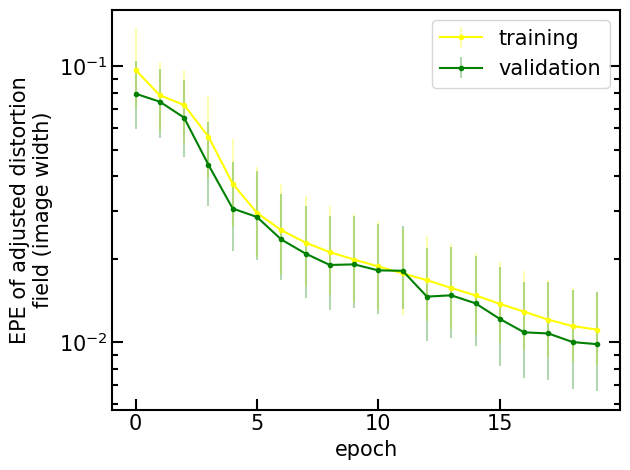

In [19]:
x_set = tuple()
y_set = tuple()
y_err_set = tuple()



for phase in phases:
    epes_of_adjusted_distortion_fields_grouped_by_epoch_map = \
        phase_to_epes_of_adjusted_distortion_fields_grouped_by_epoch_map[phase]


    
    kwargs = {"a": epes_of_adjusted_distortion_fields_grouped_by_epoch_map,
              "q": (0.25, 0.5, 0.75),
              "axis": 1}
    quantiles = np.quantile(**kwargs)


    
    y = quantiles[1]
    y_err = quantiles[[0, 2], :]
    y_err[0] = y-y_err[0]
    y_err[1] = y_err[1]-y
    x = np.arange(y.size)

    x_set += (x,)
    y_set += (y,)
    y_err_set += (y_err,)



kwargs = {"x_set": x_set, 
          "y_set": y_set, 
          "y_err_set": y_err_set, 
          "legend_label_set": phases, 
          "x_label": "epoch", 
          "y_label": "EPE of adjusted distortion\nfield (image width)"}
helpers.plot_multiple_xy_curves_with_error_bars(**kwargs)

In the plot directly above, for each phase, for each epoch, the vertical line
indicates the interquartile range, and the circle/dot indicates the median. The
metric plotted directly above is described in detail in the summary
documentation of the class
[emicroml.modelling.cbed.distortion.estimation.MLModelTrainer](https://mrfitzpa.github.io/emicroml/_autosummary/emicroml.modelling.cbed.distortion.estimation.MLModelTrainer.html).

Similarly to performance metrics, we can also extract the time-series of the
total mini-batch loss:

In [20]:
phase_to_total_mini_batch_losses_map = dict()

for phase in phases:
    hdf5_dataset_path = ("/mini_batch_losses/{}/total".format(phase))
    
    kwargs = {"filename": path_to_ml_model_training_summary_output_data,
              "path_in_file": hdf5_dataset_path}
    hdf5_dataset_id = h5pywrappers.obj.ID(**kwargs)

    kwargs = {"dataset_id": hdf5_dataset_id, "read_only": True}
    total_mini_batch_losses = h5pywrappers.dataset.load(**kwargs)[()]

    phase_to_total_mini_batch_losses_map[phase] = \
        total_mini_batch_losses

Let's group the total mini-batch losses by epoch, just as we did for the EPEs:

In [21]:
phase_to_total_mini_batch_losses_grouped_by_epoch_map = dict()

for phase in phases:
    num_mini_batches_per_epoch = \
        phase_to_num_mini_batches_per_epoch_map[phase]
    total_mini_batch_losses = \
        phase_to_total_mini_batch_losses_map[phase]



    start = 0
    stop = (total_mini_batch_losses.size
            - (total_mini_batch_losses.size % num_mini_batches_per_epoch))
    single_dim_slice = slice(start, stop)

    array_to_reshape = \
        total_mini_batch_losses[single_dim_slice]
    total_mini_batch_losses_grouped_by_epoch = \
        array_to_reshape.reshape(-1, num_mini_batches_per_epoch)


    
    phase_to_total_mini_batch_losses_grouped_by_epoch_map[phase] = \
        total_mini_batch_losses_grouped_by_epoch

and then, for both the training and validation phases, plot the first, second,
and third quartiles per epoch of the total mini-batch losses:

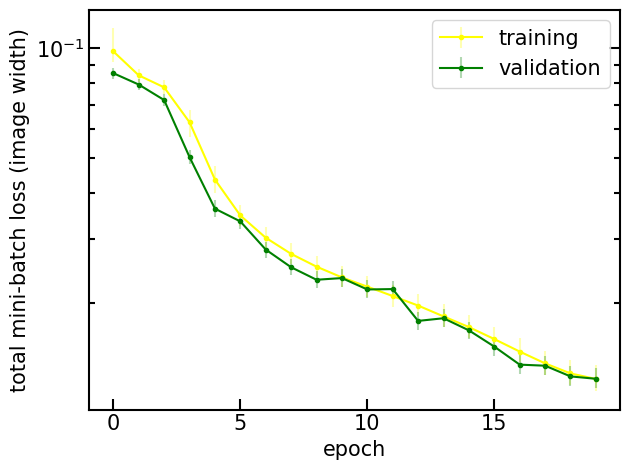

In [22]:
x_set = tuple()
y_set = tuple()
y_err_set = tuple()



for phase in phases:
    total_mini_batch_losses_grouped_by_epoch = \
        phase_to_total_mini_batch_losses_grouped_by_epoch_map[phase]


    kwargs = {"a": total_mini_batch_losses_grouped_by_epoch,
              "q": (0.25, 0.5, 0.75),
              "axis": 1}
    quantiles = np.quantile(**kwargs)


    
    y = quantiles[1]
    y_err = quantiles[[0, 2], :]
    y_err[0] = y-y_err[0]
    y_err[1] = y_err[1]-y
    x = np.arange(y.size)

    x_set += (x,)
    y_set += (y,)
    y_err_set += (y_err,)



kwargs = {"x_set": x_set, 
          "y_set": y_set, 
          "y_err_set": y_err_set, 
          "legend_label_set": phases, 
          "x_label": "epoch", 
          "y_label": "total mini-batch loss (image width)"}
helpers.plot_multiple_xy_curves_with_error_bars(**kwargs)

The total mini-batch loss plotted directly above is also described in detail in
the summary documentation of the class
[emicroml.modelling.cbed.distortion.estimation.MLModelTrainer](https://mrfitzpa.github.io/emicroml/_autosummary/emicroml.modelling.cbed.distortion.estimation.MLModelTrainer.html).

Let's circle back to the EPE of the predicted "adjusted" standard distortion
field, where this time we plot its cumulative distribution function (CDF) at the
end of training:

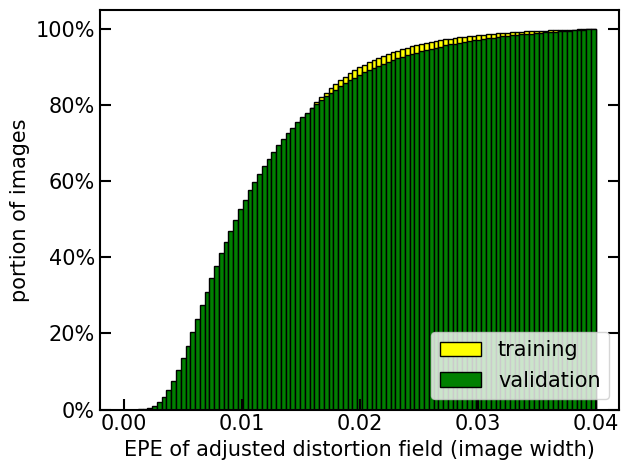

In [23]:
x_set = tuple()



for phase in phases:
    num_mini_batches_per_epoch = \
        phase_to_num_mini_batches_per_epoch_map[phase]
    epes_of_adjusted_distortion_fields = \
        phase_to_epes_of_adjusted_distortion_fields_map[phase]



    num_ml_data_instances_in_ml_dataset = \
        (num_mini_batches_per_epoch * mini_batch_size)
    num_ml_data_instances_in_ml_dataset = \
        min(num_ml_data_instances_in_ml_dataset,
            epes_of_adjusted_distortion_fields.size)



    start = -num_ml_data_instances_in_ml_dataset
    stop = None
    single_dim_slice = slice(start, stop)
    multi_dim_slice = (single_dim_slice,)



    x = epes_of_adjusted_distortion_fields[single_dim_slice]
    x_set += (x,)



kwargs = {"x_set": x_set, "legend_label_set": phases}
helpers.plot_multiple_cdf_curves(**kwargs)

## Loading and using a trained ML model ##

Let's load a trained ML model (this may take some time):

In [24]:
path_to_ml_model_state_dicts = path_to_data_dir + "/ml_models/ml_model_1"
pattern = r"ml_model_at_lr_step_[0-9]*\.pth"
largest_lr_step_idx = max([name.split("_")[-1].split(".")[0]
                           for name in os.listdir(path_to_ml_model_state_dicts)
                           if re.fullmatch(pattern, name)])

ml_model_state_dict_filename = \
    (path_to_ml_model_state_dicts
     + "/ml_model_at_lr_step_{}.pth".format(largest_lr_step_idx))



module_alias = emicroml.modelling.cbed.distortion.estimation
kwargs = {"ml_model_state_dict_filename": ml_model_state_dict_filename,
          "device_name": None}  # Default to CUDA device if available.
ml_model = module_alias.load_ml_model_from_file(**kwargs)

_ = ml_model.eval()

Alternatively, we can load the trained ML model as follows:

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

kwargs = {"f": ml_model_state_dict_filename,
          "map_location": device,
          "weights_only": True}
ml_model_state_dict = torch.load(**kwargs)


module_alias = emicroml.modelling.cbed.distortion.estimation
kwargs = {"ml_model_state_dict": ml_model_state_dict,
          "device_name": None}
ml_model = module_alias.load_ml_model_from_state_dict(**kwargs)

_ = ml_model.eval()

With the ML model loaded, let's try estimating the distortion field in a
simulated CBED pattern. First, we need to load a simulated CBED pattern:

In [26]:
path_to_ml_dataset = (path_to_data_dir
                      + "/ml_datasets/ml_dataset_for_validation.h5")

module_alias = emicroml.modelling.cbed.distortion.estimation
kwargs = {"path_to_ml_dataset": path_to_ml_dataset, 
          "entire_ml_dataset_is_to_be_cached": False, 
          "ml_data_values_are_to_be_checked": False}
ml_dataset = module_alias.MLDataset(**kwargs)



cbed_pattern_idx = 0

kwargs = \
    {"single_dim_slice": slice(cbed_pattern_idx, cbed_pattern_idx+1), 
     "sampling_grid_dims_in_pixels": sampling_grid_dims_in_pixels}
ml_data_instances_as_signals = \
    ml_dataset.get_ml_data_instances_as_signals(**kwargs)

distorted_cbed_pattern_signal = ml_data_instances_as_signals[0]

Let's plot the distorted CBED pattern:

In [27]:
%matplotlib ipympl

kwargs = {"axes_off": True, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 0.2,
          "cmap": "plasma", 
          "title": ""}
distorted_cbed_pattern_signal.plot(**kwargs)

There are essentially two ways to estimate the distortion field. The first way
is as follows:

In [28]:
distorted_cbed_pattern_image = distorted_cbed_pattern_signal.data[0]
distorted_cbed_pattern_images = distorted_cbed_pattern_image[None, :, :]
ml_inputs = {"cbed_pattern_images": distorted_cbed_pattern_images}

kwargs = {"ml_inputs": ml_inputs,
          "unnormalize_normalizable_elems_of_ml_predictions": True}
ml_predictions = ml_model.make_predictions(**kwargs)



module_alias = emicroml.modelling.cbed.distortion.estimation
kwargs = {"ml_data_dict": ml_predictions,
          "sampling_grid_dims_in_pixels": sampling_grid_dims_in_pixels}
distortion_models = module_alias.ml_data_dict_to_distortion_models(**kwargs)

distortion_model = distortion_models[0]

And the second way, which is more direct, is as follows:

In [29]:
kwargs = {"cbed_pattern_images": distorted_cbed_pattern_images,
          "sampling_grid_dims_in_pixels": sampling_grid_dims_in_pixels}
distortion_models = ml_model.predict_distortion_models(**kwargs)

distortion_model = distortion_models[0]

Note that each input distorted CBED pattern must have image dimensions, in units
of pixels, equal to
``2*(ml_model.core_attrs["num_pixels_across_each_cbed_pattern"],)``. This is
because a given ML model is trained for images of fixed dimensions, in units of
pixels.

``distortion_model`` is an instance of the class
[distoptica.DistortionModel](https://mrfitzpa.github.io/distoptica/_autosummary/distoptica.DistortionModel.html). This
object stores the predicted distortion field, and can be used to perform
distortion correction. Let's visualize the predicted distortion field:

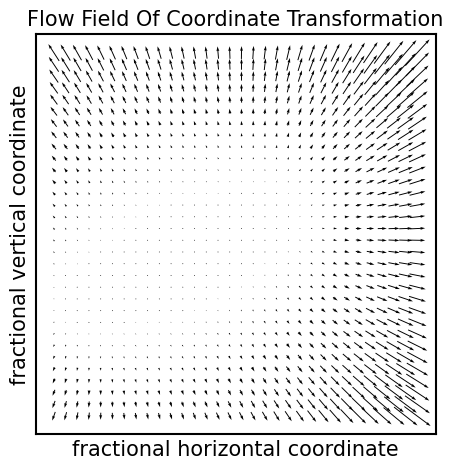

In [30]:
plt.close("all")  # Close all previous figures to release memory.
%matplotlib inline

kwargs = {"sampling_grid": distortion_model.sampling_grid,
          "flow_field": distortion_model.flow_field_of_coord_transform}
helpers.visualize_flow_field(**kwargs)

Let's now use ``distortion_model`` to correct the distortion in the original
distorted CBED pattern, according to the predicted distortion field:

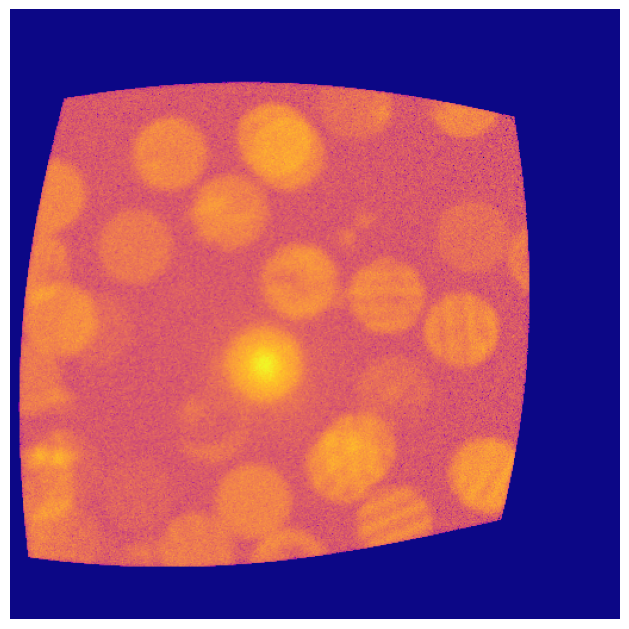

In [31]:
kwargs = \
    {"distorted_images": distorted_cbed_pattern_image[None, None, :, :]}
undistorted_then_resampled_images = \
    distortion_model.undistort_then_resample_images(**kwargs)

undistorted_cbed_pattern_image = undistorted_then_resampled_images[0, 0]
undistorted_cbed_pattern_images = undistorted_cbed_pattern_image[None, :, :]



ml_data_dict = {"cbed_pattern_images": undistorted_cbed_pattern_images}

module_alias = \
    emicroml.modelling.cbed.distortion.estimation
kwargs = \
    {"ml_data_dict": ml_data_dict,
     "sampling_grid_dims_in_pixels": sampling_grid_dims_in_pixels}
undistorted_cbed_pattern_signals = \
    module_alias.ml_data_dict_to_signals(**kwargs)

undistorted_cbed_pattern_signal = undistorted_cbed_pattern_signals[0]

kwargs = {"axes_off": True, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 0.2,
          "cmap": "plasma", 
          "title": ""}
undistorted_cbed_pattern_signal.inav[0].plot(**kwargs)

Note how the CBED disks are now much more circular, which indicates
qualitatively that the ML model did a reasonable job predicting the distortion
field.

Another useful instance attribute in this context is
[distoptica.DistortionModel.out_of_bounds_map_of_undistorted_then_resampled_images](https://mrfitzpa.github.io/distoptica/_autosummary/distoptica.DistortionModel.html#distoptica.DistortionModel.out_of_bounds_map_of_undistorted_then_resampled_images):

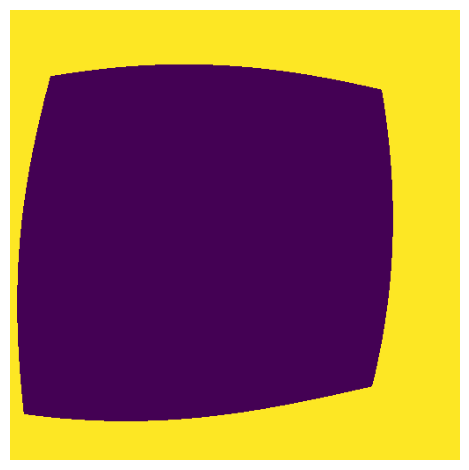

In [32]:
out_of_bounds_map_of_undistorted_then_resampled_images = \
    distortion_model.out_of_bounds_map_of_undistorted_then_resampled_images
out_of_bounds_map_of_undistorted_then_resampled_images = \
    out_of_bounds_map_of_undistorted_then_resampled_images.numpy(force=True)

fig, ax = plt.subplots()

ax.imshow(out_of_bounds_map_of_undistorted_then_resampled_images)

ax.axis("off")

plt.tight_layout()
plt.show()

## A note on ``fancytypes`` ##

The variables ``ml_dataset``, ``ml_model_trainer``, and ``distortion_model``,
used throughout the notebook, reference instances of subclasses of the
[fancytypes.PreSerializableAndUpdatable](https://mrfitzpa.github.io/fancytypes/_autosummary/fancytypes.PreSerializableAndUpdatable.html)
class.  One of the nice features of this class is that an instance of a subclass
thereof can be serialize straightforwardly and later reconstructed from the said
serialized representation. For example, let's serialize ``ml_dataset``:

In [33]:
serialized_rep_of_ml_dataset = ml_dataset.dumps()
serialized_rep_of_ml_dataset

'{"path_to_ml_dataset": "../data/ml_datasets/ml_dataset_for_validation.h5", "entire_ml_dataset_is_to_be_cached": false, "ml_data_values_are_to_be_checked": false, "max_num_ml_data_instances_per_chunk": 100}'

Now let's reconstruct ``ml_dataset`` from its serialized representation:

In [34]:
module_alias = emicroml.modelling.cbed.distortion.estimation
kwargs = {"serialized_rep": serialized_rep_of_ml_dataset}
ml_dataset = module_alias.MLDataset.loads(**kwargs)
ml_dataset

The
[fancytypes.PreSerializableAndUpdatable](https://mrfitzpa.github.io/fancytypes/_autosummary/fancytypes.PreSerializableAndUpdatable.html)
has other nice features, which you can read about in more detail in the
documentation thereof.